In [ ]:
%pip install xgboost


In [20]:
# XGBoost Classifier -
# --- Step 1: Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

import xgboost as xgb
from sklearn.utils import resample

sns.set(style="whitegrid")

In [21]:
# --- Step 2: Load dataset ---
df = pd.read_csv("C:/Users/DELL/Desktop/MSc/1st Sem/AML/Loan_Default - Copy.csv")  
print("Raw shape:", df.shape)
print(df.columns.tolist()[:40])

Raw shape: (49999, 34)
['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status', 'dtir1']


In [22]:
# Drop ID if present (IDENTIFIERS must be removed)
if "ID" in df.columns:
    print("Dropping ID column.")
    df = df.drop(columns=["ID"])

Dropping ID column.


In [23]:
# --- Step 3: Exploratory checks (missing + class balance) ---
# Missing values table
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(df)) * 100
missing_table = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percent})
print("\nMissing values (top rows):")
print(missing_table[missing_table["Missing Values"] > 0].head(30))


Missing values (top rows):
                           Missing Values  Percentage
Upfront_charges                     13287   26.574531
Interest_rate_spread                12281   24.562491
rate_of_interest                    12209   24.418488
dtir1                                8072   16.144323
property_value                       5104   10.208204
LTV                                  5104   10.208204
income                               3008    6.016120
loan_limit                           1109    2.218044
approv_in_adv                         277    0.554011
submission_of_application              72    0.144003
age                                    72    0.144003
Neg_ammortization                      40    0.080002
loan_purpose                           38    0.076002
term                                   16    0.032001


Class counts:
 Status
0    37718
1    12281
Name: count, dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_3280\3962594985.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Status", data=df, palette="coolwarm")


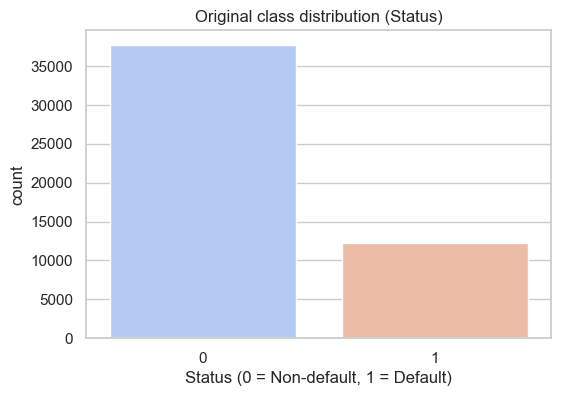

In [25]:
#Class Distribution (numbers)
class_counts = y.value_counts()
print("Class counts:\n", class_counts)

# Class distribution (original)
plt.figure(figsize=(6,4))
sns.countplot(x="Status", data=df, palette="coolwarm")
plt.title("Original class distribution (Status)")
plt.xlabel("Status (0 = Non-default, 1 = Default)")
plt.show()

In [26]:
#class distribution (%)
class_percent = y.value_counts(normalize=True) * 100
print("\nClass percentages : \n",class_percent.round(2))


Class percentages : 
 Status
0    75.44
1    24.56
Name: proportion, dtype: float64


In [6]:
# --- Step 4: Split features/target and Train/Test split (do this BEFORE fitting imputers/encoders) ---
X_raw = df.drop(columns=["Status"], errors="ignore")
y = df["Status"]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)
print("Train raw shape:", X_train_raw.shape, "Test raw shape:", X_test_raw.shape)

Train raw shape: (39999, 32) Test raw shape: (10000, 32)


In [7]:
# --- Step 5: Preprocessing fitted on training data only (impute numeric, impute categorical, encode) ---
# Identify numeric and categorical columns from training data
num_cols = X_train_raw.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train_raw.select_dtypes(include=["object","category"]).columns.tolist()
print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

# Numeric imputer (median) - fit on train only
num_imputer = SimpleImputer(strategy="median")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train_raw[num_cols]), columns=num_cols, index=X_train_raw.index)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test_raw[num_cols]), columns=num_cols, index=X_test_raw.index)

# Categorical imputer (most frequent) - fit on train only
cat_imputer = SimpleImputer(strategy="most_frequent")
if cat_cols:
    X_train_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(X_train_raw[cat_cols]), columns=cat_cols, index=X_train_raw.index)
    X_test_cat_imputed  = pd.DataFrame(cat_imputer.transform(X_test_raw[cat_cols]), columns=cat_cols, index=X_test_raw.index)
else:
    X_train_cat_imputed = pd.DataFrame(index=X_train_raw.index)
    X_test_cat_imputed  = pd.DataFrame(index=X_test_raw.index)

Numeric cols: 11 Categorical cols: 21


In [ ]:
# One-hot encode categoricals (fit on train only)
if cat_cols:
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
    enc_train = encoder.fit_transform(X_train_cat_imputed)
    enc_test  = encoder.transform(X_test_cat_imputed)
    enc_cols = encoder.get_feature_names_out(cat_cols)
    X_train_cat = pd.DataFrame(enc_train, columns=enc_cols, index=X_train_raw.index)
    X_test_cat  = pd.DataFrame(enc_test, columns=enc_cols, index=X_test_raw.index)
else:
    X_train_cat = pd.DataFrame(index=X_train_raw.index)
    X_test_cat  = pd.DataFrame(index=X_test_raw.index)

# Combine numeric + encoded categorical
X_train_pre = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_pre  = pd.concat([X_test_num,  X_test_cat],  axis=1)

print("Preprocessed train shape:", X_train_pre.shape, "Preprocessed test shape:", X_test_pre.shape)

# sanity check that columns line up
assert list(X_train_pre.columns) == list(X_test_pre.columns), "Train/test columns mismatch after preprocessing."

Preprocessed train shape: (39999, 49) Preprocessed test shape: (10000, 49)


In [9]:
# --- Step 6: Inspect feature correlations with target (optional, informative) ---
# Quick top correlations (numerical only)
corrs = X_train_pre.select_dtypes(include=[np.number]).corrwith(y_train).abs().sort_values(ascending=False)
print("\nTop correlations with target (train):")
print(corrs.head(15))

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Top correlations with target (train):
credit_type_EQUI                     0.591761
lump_sum_payment_not_lpsm            0.183056
Neg_ammortization_not_neg            0.158907
co-applicant_credit_type_EXP         0.146182
credit_type_CRIF                     0.125788
submission_of_application_to_inst    0.122987
credit_type_EXP                      0.121035
Upfront_charges                      0.096115
business_or_commercial_nob/c         0.089721
loan_type_type2                      0.089721
dtir1                                0.082115
Gender_Joint                         0.075496
property_value                       0.073119
loan_limit_ncf                       0.058464
income                               0.057873
dtype: float64


In [12]:
# --- Fix column names for XGBoost ---
def clean_column_names(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace('[', '(', regex=False)
        .str.replace(']', ')', regex=False)
        .str.replace('<', 'lt', regex=False)
        .str.replace('>', 'gt', regex=False)
        .str.replace('=', '_', regex=False)
        .str.replace(' ', '_', regex=False)
    )
    return df

X_train_pre = clean_column_names(X_train_pre)
X_test_pre  = clean_column_names(X_test_pre)

print("Preprocessed train shape:", X_train_pre.shape)
print("Preprocessed test shape:", X_test_pre.shape)

Preprocessed train shape: (39999, 49)
Preprocessed test shape: (10000, 49)



After SMOTE class distribution (train):
Status
0    30174
1    30174
Name: count, dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_3280\747425690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette="viridis")


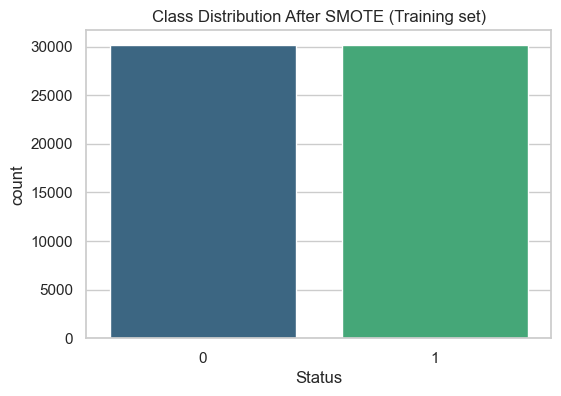

In [13]:
# --- Step 7: Apply SMOTE on training set only (XGBoost is tree-based so scaling not required) ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_pre, y_train)
print("\nAfter SMOTE class distribution (train):")
print(pd.Series(y_train_res).value_counts())

# Visualize balanced training set
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res, palette="viridis")
plt.title("Class Distribution After SMOTE (Training set)")
plt.xlabel("Status")
plt.show()

In [14]:
# --- Step 8: Baseline XGBoost model (fast) ---
xgb_base = xgb.XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False)
# If your xgboost version warns about use_label_encoder, you may remove that parameter.
xgb_base.fit(X_train_res, y_train_res)

y_pred_base = xgb_base.predict(X_test_pre)
y_proba_base = xgb_base.predict_proba(X_test_pre)[:,1]

print("\nBaseline XGBoost results:")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base))
print("ROC-AUC (baseline):", roc_auc_score(y_test, y_proba_base))

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Baseline XGBoost results:
Confusion matrix:
 [[7543    1]
 [   0 2456]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7544
           1       1.00      1.00      1.00      2456

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC (baseline): 1.0


In [15]:
# --- Step 9: Hyperparameter tuning (RandomizedSearchCV - small search to save time) ---
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.5]
}

rs = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs.fit(X_train_res, y_train_res)
print("\nBest params (RandomizedSearchCV):", rs.best_params_)

best_xgb = rs.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:44:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best params (RandomizedSearchCV): {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [16]:
# --- Step 10: Final evaluation on test set ---
y_pred = best_xgb.predict(X_test_pre)
y_proba = best_xgb.predict_proba(X_test_pre)[:,1]

print("\nTuned XGBoost results:")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC (tuned):", roc_auc_score(y_test, y_proba))


Tuned XGBoost results:
Confusion matrix:
 [[7544    0]
 [   0 2456]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7544
           1       1.00      1.00      1.00      2456

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC (tuned): 1.0


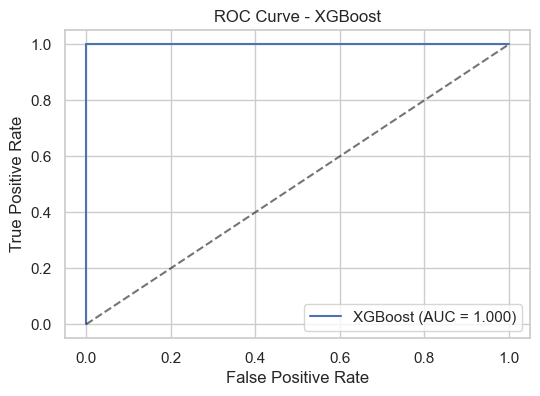

In [17]:
# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

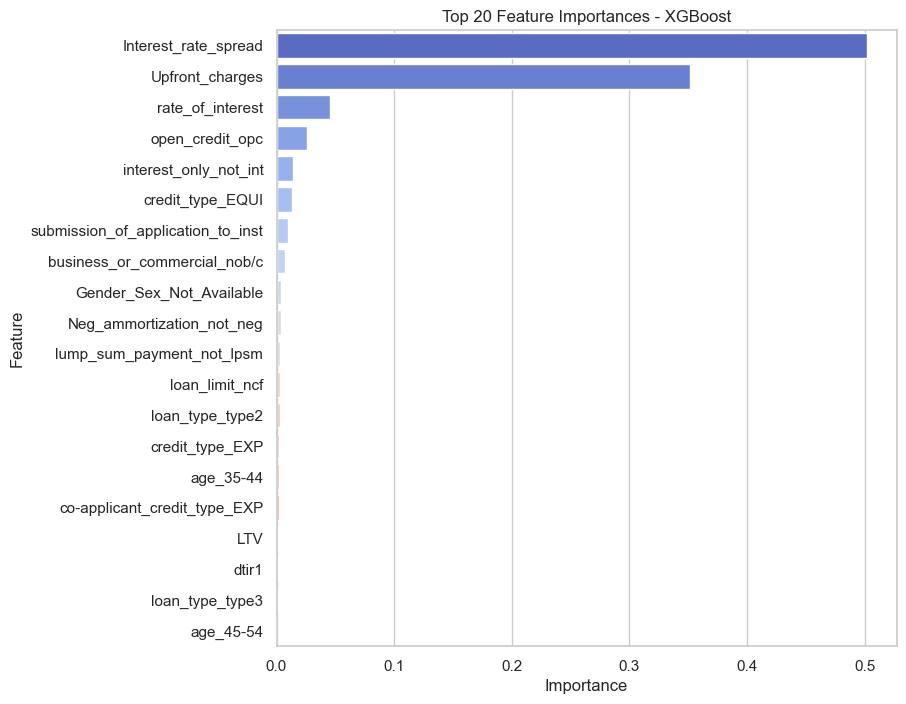

In [18]:
# --- Step 11: Feature importance (Top 20) ---
feat_imp = pd.DataFrame({
    "Feature": X_train_pre.columns,
    "Importance": best_xgb.feature_importances_
}).sort_values("Importance", ascending=False).head(20)

colors = sns.color_palette("coolwarm", len(feat_imp))
plt.figure(figsize=(8,8))
sns.barplot(x="Importance", y="Feature", data=feat_imp, hue="Feature", palette=colors, dodge=False, legend=False)
plt.title("Top 20 Feature Importances - XGBoost")
plt.show()

In [ ]:
# --- Step 12: Notes / next steps ---
print("\nNotes:")
print("- Preprocessing (imputation/encoding) was fit on the training set only to avoid leakage.")
print("- SMOTE applied only to training set.")
print("- XGBoost is tree-based: scaling not required.")
print("- If tuning takes too long, reduce n_iter or cv, or tune on a smaller sample and then refit on full train set.")

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier

# --- Shuffled target test ---
def shuffled_target_test(model, X_train, y_train, X_test, y_test):
    """Train with shuffled target to test for leakage."""
    y_train_shuffled = np.random.permutation(y_train)
    model.fit(X_train, y_train_shuffled)
    acc = model.score(X_test, y_test)
    print("Accuracy with shuffled target:", acc)
    return acc

# --- Shallow tree test ---
def shallow_tree_test(X_train, y_train, X_test, y_test):
    """Fit a weak decision tree to test dataset complexity / leakage."""
    dt_test = DecisionTreeClassifier(random_state=42, max_depth=3)
    dt_test.fit(X_train, y_train)
    acc = dt_test.score(X_test, y_test)
    print("Shallow tree test accuracy:", acc)
    return acc

# --- Cross-validation test ---
def cross_validation_test(model, X, y, cv=5):
    """Cross-validation scores."""
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())
    return scores

# --- Learning curve plot ---
def plot_learning_curve(model, X, y, cv=5, title="Learning Curve"):
    """Plot learning curves for train and validation sets."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, label="Train score", marker="o")
    plt.plot(train_sizes, val_mean, label="Validation score", marker="o")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy with shuffled target: 0.4962
Shallow tree test accuracy: 1.0
Cross-validation scores: [1.         0.9998343  0.99991715 1.         1.        ]
Mean accuracy: 0.999950289975145


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgb

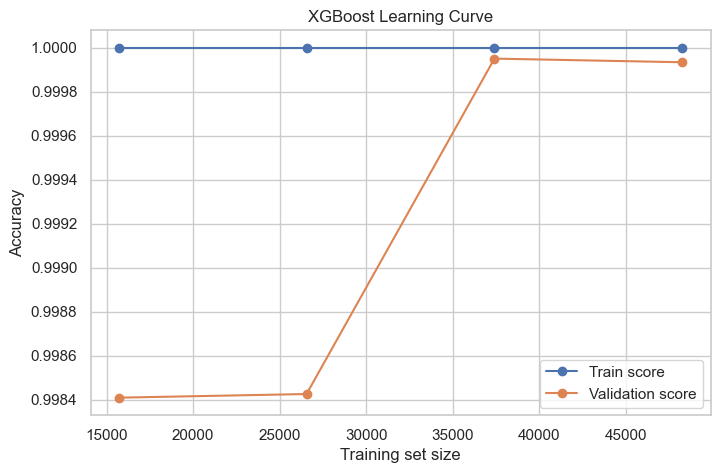

In [32]:
# --- XGBoost Sanity Checks ---
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False)

# 1. Shuffled target test
shuffled_target_test(xgb_clf, X_train_res, y_train_res, X_test_pre, y_test)

# 2. Shallow tree test
shallow_tree_test(X_train_res, y_train_res, X_test_pre, y_test)

# 3. Cross-validation
cross_validation_test(xgb_clf, X_train_res, y_train_res)

# 4. Learning curve
plot_learning_curve(xgb_clf, X_train_res, y_train_res, title="XGBoost Learning Curve")
